# Replicating Examples from "The Effect"

This notebook replicates code examples from Nick Huntington-Klein's book on causal inference, [The Effect](https://theeffectbook.net/). 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pyfixest.estimation import feols
from pyfixest.summarize import summary

## Chapter 4: Describing Relationships

In [2]:
from causaldata import Mroz

# Read in data
dt = Mroz.load_pandas().data
# Keep just working women
dt = dt[dt["lfp"] == True]
# Create unlogged earnings
dt.loc[:, "earn"] = dt["lwg"].apply("exp")

# 5. Run multiple linear regression models by succesively adding controls
fit = feols(fml = "lwg ~ csw(inc, wc, k5)", data = dt, vcov="iid")
summary(fit)

Model:  lwg~inc
###

Model:  OLS
Dep. var.:  lwg
Inference:  iid
Observations:  428

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |      1.007 |        0.071 |    14.180 |      0.000 |   0.868 |    1.147 |
| inc           |      0.010 |        0.003 |     2.947 |      0.003 |   0.003 |    0.016 |
---
RMSE: 0.715  Adj. R2: 0.015  Adj. R2 Within: 0.015


C:\Users\alexa\AppData\Local\Temp\ipykernel_18568\1676904683.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt.loc[:, "earn"] = dt["lwg"].apply("exp")


## Chapter 13: Regression

### Example 1

In [3]:
from causaldata import restaurant_inspections

res = restaurant_inspections.load_pandas().data
res.inspection_score = res.inspection_score.astype(float)
res.NumberofLocations = res.NumberofLocations.astype(float)
res.dtypes

fit = feols(fml = "inspection_score ~ NumberofLocations", data = res)
summary(fit)

Model:  inspection_score~NumberofLocations
###

Model:  OLS
Dep. var.:  inspection_score
Inference:  iid
Observations:  27178

| Coefficient       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:------------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept         |     94.866 |        0.046 |  2049.047 |      0.000 |  94.775 |   94.956 |
| NumberofLocations |     -0.019 |        0.000 |   -43.321 |      0.000 |  -0.020 |   -0.018 |
---
RMSE: 6.051  Adj. R2: 0.065  Adj. R2 Within: 0.065


### Example 2

In [4]:
df = restaurant_inspections.load_pandas().data

fit1 = feols(fml = "inspection_score ~ NumberofLocations + I(NumberofLocations^2) + Year", data = df)
fit2 = feols(fml = "inspection_score ~ NumberofLocations*Weekend + Year", data = df)

summary([fit1, fit2])

Model:  inspection_score~NumberofLocations+I(NumberofLocations^2)+Year
Model:  inspection_score~NumberofLocations*Weekend+Year
###

Model:  OLS
Dep. var.:  inspection_score
Inference:  iid
Observations:  27178

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:-----------------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept              |    225.504 |       12.409 |    18.172 |      0.000 | 201.181 |  249.827 |
| NumberofLocations      |     -0.075 |        0.019 |    -4.041 |      0.000 |  -0.111 |   -0.039 |
| I(NumberofLocations^2) |      0.056 |        0.019 |     3.009 |      0.003 |   0.020 |    0.093 |
| Year                   |     -0.065 |        0.006 |   -10.527 |      0.000 |  -0.077 |   -0.053 |
---
RMSE: 6.038  Adj. R2: 0.069  Adj. R2 Within: 0.069
###

Model:  OLS
Dep. var.:  inspection_score
Inference:  iid
Observations:  27178

| Coefficient               |   Estimate |  

### Example 3: HC Standard Errors

In [5]:
feols(fml = "inspection_score ~ Year + Weekend", data = df, vcov="HC3").summary()

Model:  inspection_score~Year+Weekend
###

Model:  OLS
Dep. var.:  inspection_score
Inference:  HC3
Observations:  27178

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |    185.380 |       12.150 |    15.257 |      0.000 | 161.564 |  209.196 |
| Year          |     -0.046 |        0.006 |    -7.551 |      0.000 |  -0.057 |   -0.034 |
| Weekend       |      2.057 |        0.353 |     5.829 |      0.000 |   1.365 |    2.749 |
---
RMSE: 6.248  Adj. R2: 0.003  Adj. R2 Within: 0.003


### Example 4: Clustered Standard Errors

In [6]:
feols(fml = "inspection_score ~ Year + Weekend", data = df, vcov={"CRV1": "Weekend"}).tidy()

Model:  inspection_score~Year+Weekend


,Estimate,Std. Error,t value,Pr(>|t|),2.5 %,97.5 %
Coefficient,,,,,,
Intercept,185.380033,3.264345,56.789343,0.011209,143.902592,226.857474
Year,-0.045640,0.001624,-28.107556,0.022640,-0.066272,-0.025008
Weekend,2.057166,0.001401,1468.256800,0.000434,2.039364,2.074969


### Example 5: Bootstrap Inference 

In [7]:
fit = feols(fml = "inspection_score ~ Year + Weekend", data = df)
fit.wildboottest(B=999, param="Year")

Model:  inspection_score~Year+Weekend


param              Year
statistic        -7.552
pvalue              0.0
bootstrap_type       11
impose_null        True
dtype: object

## Chapter 16: Fixed Effects

### Example 1

tba

### Example 2

In [8]:
from causaldata import gapminder

gm = gapminder.load_pandas().data
gm["logGDPpercap"] = gm["gdpPercap"].apply("log")

fit = feols(fml = "lifeExp ~ C(country) + np.log(gdpPercap)", data = gm)
fit.tidy().head()

Model:  lifeExp~C(country)+np.log(gdpPercap)


,Estimate,Std. Error,t value,Pr(>|t|),2.5 %,97.5 %
Coefficient,,,,,,
Intercept,-27.773459,2.500533,-11.107015,0.000000e+00,-32.678217,-22.868701
C(country)[T.Albania],17.782625,2.195160,8.100835,1.110223e-15,13.476853,22.088397
C(country)[T.Algeria],5.241055,2.214496,2.366704,1.806875e-02,0.897356,9.584755
C(country)[T.Angola],-13.907122,2.201727,-6.316460,3.481857e-10,-18.225777,-9.588468
C(country)[T.Argentina],8.132158,2.272781,3.578065,3.567229e-04,3.674133,12.590183


### Example 3: TWFE

In [9]:
# Set our individual and time (index) for our data
fit = feols(fml = "lifeExp ~ np.log(gdpPercap) | country + year", data = gm)
fit.summary()

Model:  lifeExp~np.log(gdpPercap)|country+year
###

Model:  OLS
Dep. var.:  lifeExp
Fixed effects:  country+year
Inference:  CRV1
Observations:  1704

| Coefficient       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:------------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| np.log(gdpPercap) |      1.450 |        0.677 |     2.141 |      0.034 |   0.111 |    2.788 |
---
RMSE: 3.267  Adj. R2: 0.018  Adj. R2 Within: 0.018


## Chapter 18: Difference-in-Differences

### Example 1

In [10]:
from causaldata import organ_donations

od = organ_donations.load_pandas().data

# Create Treatment Variable
od["California"] = od["State"] == "California"
od["After"] = od["Quarter_Num"] > 3
od["Treated"] = 1 * (od["California"] & od["After"])

did = feols(fml = "Rate ~ Treated | State + Quarter", data = od)
did.summary()

Model:  Rate~Treated|State+Quarter
###

Model:  OLS
Dep. var.:  Rate
Fixed effects:  State+Quarter
Inference:  CRV1
Observations:  162

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Treated       |     -0.022 |        0.006 |    -3.733 |      0.001 |  -0.035 |   -0.010 |
---
RMSE: 0.022  Adj. R2: 0.003  Adj. R2 Within: 0.003


### Example 3: Dynamic Treatment Effect

Model:  Rate~i(Quarter_Num,California,ref=3)|State+Quarter_Num


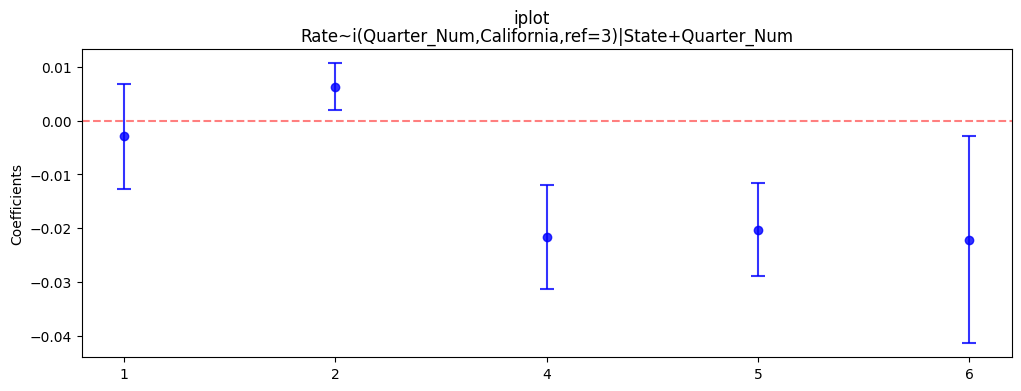

In [11]:
import matplotlib as plt
from causaldata import organ_donations

od = organ_donations.load_pandas().data

# Create Treatment Variable
od["California"] = od["State"] == "California"
od["Quarter_Num"] = pd.Categorical(od.Quarter_Num)
od["California"] = od.California.astype(float)

did2 = feols(fml = "Rate ~ i(Quarter_Num, California, ref = 3) | State + Quarter_Num", data = od)
did2.iplot(yintercept=0, figsize = (12, 4))